# Covid19 notebook. People hostipalized in Spain.
In this notebook, I try to analyze data from covid19 in Spain. I examine the variation of people hospitalized by covid19. We use data from the Spanish government download from https://covid19.isciii.es/resources/serie_historica_acumulados.csv

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import pycountry
import argparse
from covid19_definitions import *
import datetime as dt
from typing import List

In [29]:
def plot(dates: List, value: List, 
         title: str = "", 
         file_to_save: str = None) -> None:
    """
    Plot a graph
    :param dates: x values
    :param value: y value
    :param title:
    :param file_to_save: Name file to save, None, not save
    :return:
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(dates, value)
    fig.autofmt_xdate()
    plt.axvline(DATE_INIT_CONFINEMENT, 
                color='r', 
                label='Confinement')
    plt.axvline(DATE_INIT_HARD_CONFINEMENT, 
                color='orange', 
                label='Hard Confinement')
    plt.legend()
    if file_to_save is not None:
        fig.savefig(file_to_save)
        
    


In [30]:
def ca_get_name(code: str) -> str:
    try:
        st = pycountry.subdivisions.get(code='ES-' + code)
        return st.name.split(',')[0].split('/')[0]
    except:
        return code

In [31]:
def get_diff_hospitalized_by_day(df: pd.DataFrame) -> List:
    return df[SZ_COLUMN_HOSPITALIZED] - df[SZ_COLUMN_HOSPITALIZED].shift(1).fillna(0)

## Get data 
Get panda dataframe with data about covid19 in Spain from the Spanish government.

In [32]:
r = requests.get(URL_FILE_CSV, allow_redirects=True)
open('serie_historica_acumulados.csv', 'wb').write(r.content)
df_read = pd.read_csv("serie_historica_acumulados.csv", encoding=FILE_ENCODING)
df = df_read[COLUMNS_USE].copy()
df["Date"] = pd.to_datetime(df[SZ_COLUMN_DATE], format='%d/%m/%Y')
df[SZ_COLUMN_HOSPITALIZED] = df[SZ_COLUMN_HOSPITALIZED].fillna(0)
df = df.dropna()


In [33]:
# Create data to all Spain (df_es) and Galician(df_ga)
df_ga=df[df[SZ_COLUMN_CA]=="GA"]
df_es=df.groupby("Date").sum()
df_es["Date"]=df_es.index

In [34]:
print("Date from {0} to {1}".format(df["Date"].min().date(),df["Date"].max().date()))

Date from 2020-02-20 to 2020-04-09


## Plot data from Spain and Galician

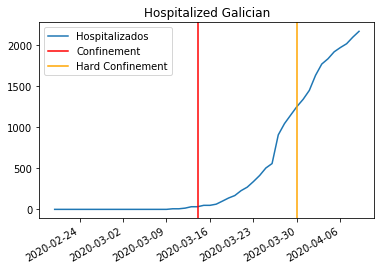

In [35]:
plot(df_ga["Date"] , 
     df_ga["Hospitalizados"], 
     title="Hospitalized Galician")

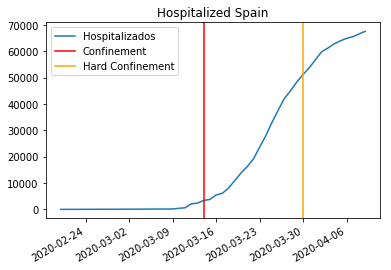

In [36]:
plot(df_es["Date"] , df_es["Hospitalizados"], title="Hospitalized Spain")

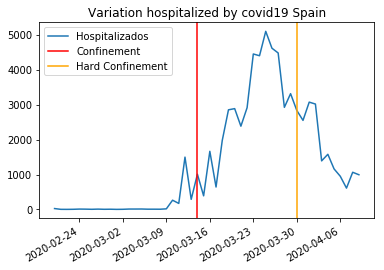

In [37]:
plot(df_es["Date"],
     get_diff_hospitalized_by_day(df_es),
     title="Variation hospitalized by covid19 Spain",
     file_to_save=FILE_VARIATION_SP)

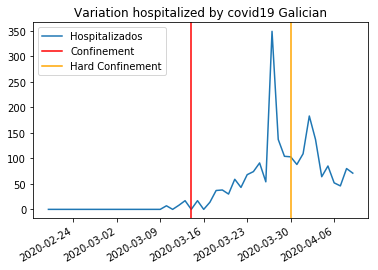

In [40]:
plot(df_ga["Date"], 
      get_diff_hospitalized_by_day(df_ga),
     title="Variation hospitalized by covid19 Galician", 
     file_to_save="VariationGalician")

## Plot data by community

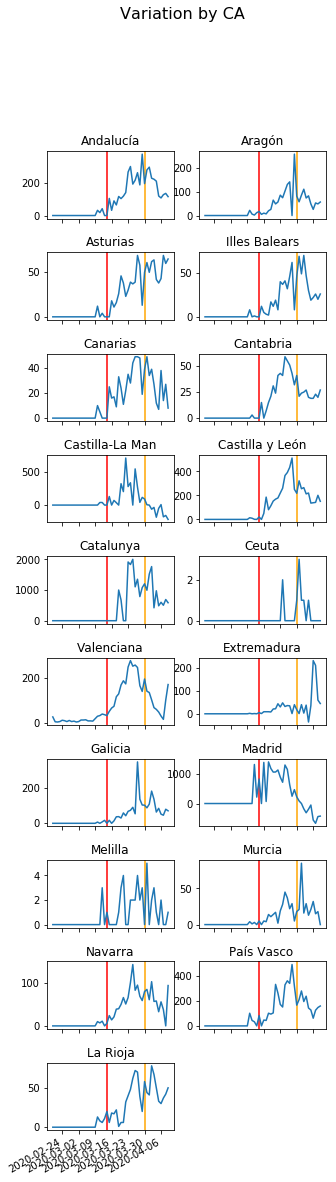

In [46]:
lst_ca=list(df[SZ_COLUMN_CA].unique())
n_columns=2
n_rows= math.ceil(len(lst_ca) /  n_columns)
fig, ax = plt.subplots( n_rows , 
                       n_columns,
                       figsize=(5, 20))
for ca in lst_ca:
    index=lst_ca.index(ca)
    column = math.floor(index/n_columns)
    row = index - column * n_columns
    df_ca = df[df[SZ_COLUMN_CA] == ca]    
    values = get_diff_hospitalized_by_day(df_ca)
    ax[column, row].axvline(DATE_INIT_CONFINEMENT, color='r')
    ax[column, row].axvline(DATE_INIT_HARD_CONFINEMENT, color='orange')
    ax[column, row].set_title(ca_get_name(ca)[:15])
    ax[column, row].plot(df_ca["Date"], values)
plt.subplots_adjust(hspace=0.5)
fig.autofmt_xdate()
if len(lst_ca) %2 != 0:
    fig.delaxes(ax[ n_rows -1, n_columns - 1] )
    
fig.suptitle("Variation by CA", fontsize=16)
fig.savefig(FILE_VARIATION_BY_CA, format='png')
